https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from keras import backend as K
from tensorflow.keras.utils import plot_model
import random
from keras.regularizers import L2
import plotly.graph_objs as go
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
# load final clean dataset
df = pd.read_csv('merged_clean_data.csv')

In [3]:
# df.set_index('Date/Time', inplace = True)
print(df[df['provincename'] == 'Quebec'].index.min())
print(df[df['provincename'] == 'Quebec'].index.max())

0
79435


In [4]:
# convert date/time to date time format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# filter data to remove the rows that doesn't have productivity values
df = df[df['Date/Time'] <= '2021-12-31']

# set date/time as index
df.set_index('Date/Time', inplace = True)

# drop unnecessary columns
sectors_todrop = ['Manufacturing', 'Utilities', 'Educational services', 'Accommodation and food services', 'Other services except public administration',
                  'Public administration', 'Finance and insurance, real estate and rental and leasing', 'Professional scientific and technical services',
                  'Information culture and recreation']

df.drop(columns = sectors_todrop, inplace = True)

# convert 'GeoUID' to string
df['GeoUID'] = df['GeoUID'].astype('str')

# rename columns
df.rename(columns={'Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction': 'Agriculture'}, inplace=True)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85601 entries, 1998-01-01 to 2017-12-01
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   provincename                       85601 non-null  object 
 1   Longitude                          85601 non-null  float64
 2   Latitude                           85601 non-null  float64
 3   Region.Name                        85601 non-null  object 
 4   Construction                       85601 non-null  float64
 5   Transportation and warehousing     85601 non-null  float64
 6   Health care and social assistance  85601 non-null  float64
 7   Agriculture                        85601 non-null  float64
 8   Wholesale trade Retail trade       85601 non-null  float64
 9   Population                         85601 non-null  float64
 10  GeoUID                             85601 non-null  object 
 11  Station Name                       85

## (1) Univariate ##

(1.1) Combination of all 5 provinces

In [6]:
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [7]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Agriculture
Date/Time              
1998-01-31   136.633187
1998-02-28   134.821698
1998-03-31   133.522822
1998-04-30   131.683532
1998-05-31   130.029725


<Axes: title={'center': 'Agriculture'}, xlabel='Date/Time'>

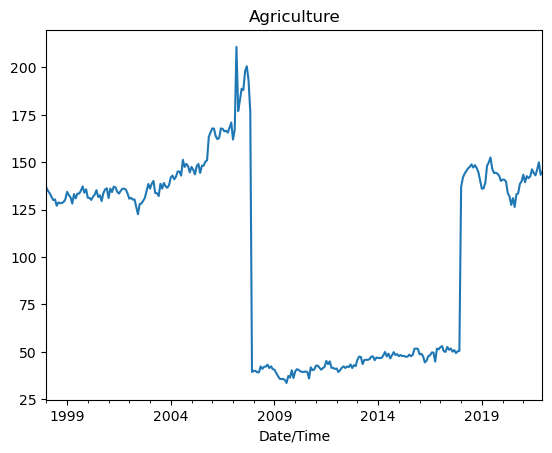

In [8]:
lstm_data = pd.DataFrame(resampled['Agriculture'])
print(lstm_data.head(5))
lstm_data['Agriculture'].plot(title = 'Agriculture')

In [9]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 877.0909423828125
R-squared from the last epoch: -53.73194122314453
Val Mean Squared Error (MSE) from the last epoch: 739.6311645507812
Val R-squared from the last epoch: -11.32324504852295


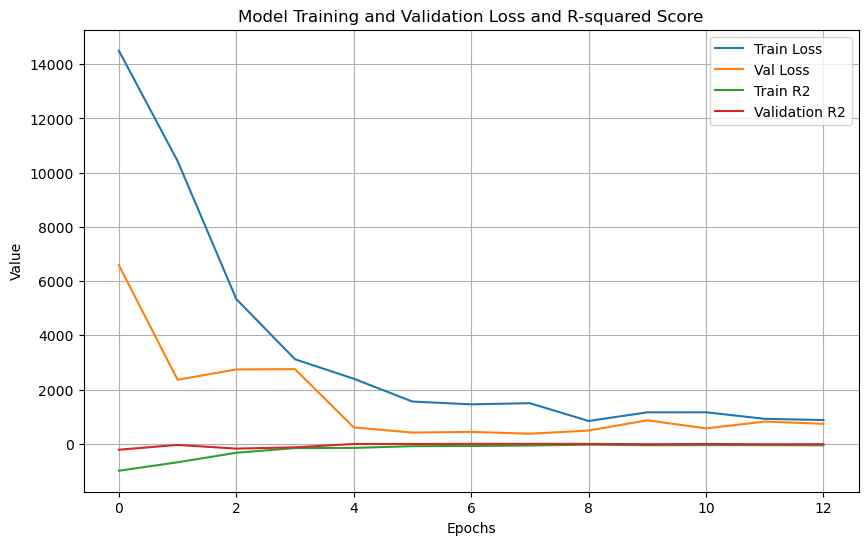

1/1 [==============================] - 0s 33ms/step - loss: 48.1642 - r_squared: -0.4721
MSE and R_squared: [48.164207458496094, -0.47208309173583984]
1/1 [==============================] - 1s 501ms/step
Predictions:
[149.26662, 135.44153, 150.17114, 144.6268, 149.33087, 148.15921, 142.12906, 142.7701, 141.14146, 143.0504]
Actual values:
[144.32583, 144.45656, 143.99639, 142.9033, 140.13076, 140.84548, 140.74626, 139.7706, 133.70474, 131.9854]


In [10]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(n_steps, n_features), return_sequences=True)))
model.add(Dropout(0.7))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))


def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model

from keras.optimizers import Adam

optimizer = Adam(learning_rate = 0.001, clipnorm=1.0)
model.compile(optimizer = optimizer, 
              loss = 'mse',
              metrics = [r_squared])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 100,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping],
          validation_split = 0.2,
          shuffle = False)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='LSTM Univariate Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.2) Alberta

In [11]:
resampled_AB = df[df['provincename'] == 'Alberta']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_AB.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [12]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Agriculture
Date/Time              
1998-01-31   653.820231
1998-02-28   648.789626
1998-03-31   645.530682
1998-04-30   622.510014
1998-05-31   624.691306


<Axes: title={'center': 'Agriculture'}, xlabel='Date/Time'>

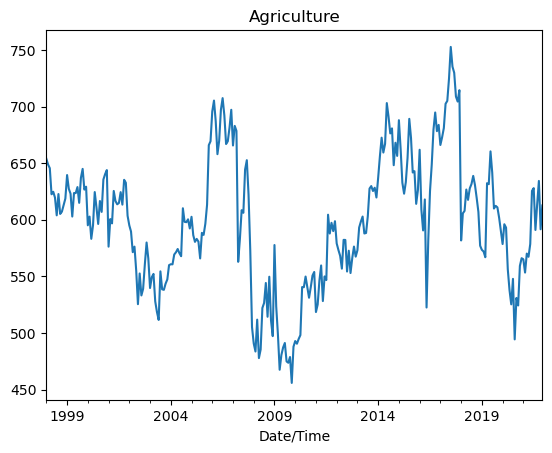

In [13]:
lstm_data = pd.DataFrame(resampled['Agriculture'])
print(lstm_data.head(5))
lstm_data['Agriculture'].plot(title = 'Agriculture')

In [14]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 684.6411743164062
R-squared from the last epoch: 0.8132042288780212


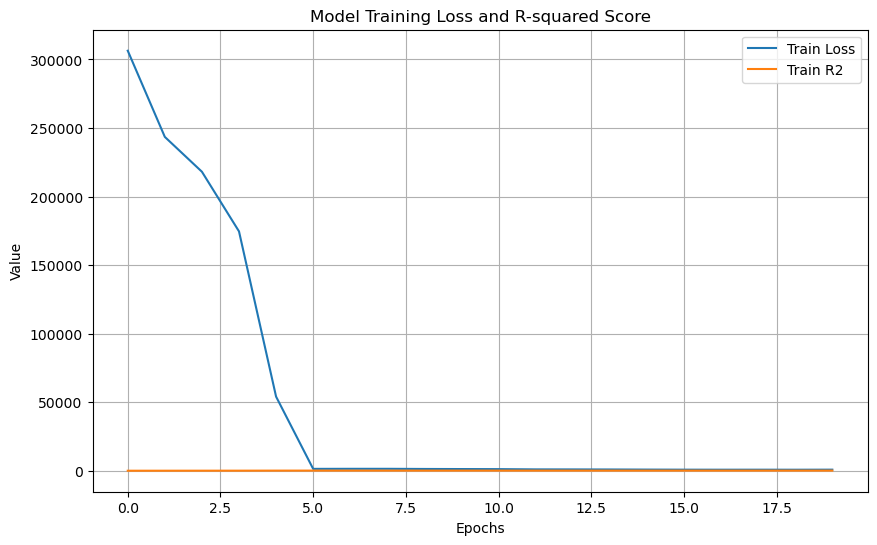

1/1 [==============================] - 0s 256ms/step - loss: 646.6143 - r_squared: 0.4577
MSE and R_squared: [646.6143188476562, 0.45769768953323364]
1/1 [==============================] - 0s 186ms/step
Predictions:
[614.8873, 609.3517, 613.1057, 614.9935, 610.1531, 603.49634, 591.47406, 588.3785, 586.39355, 570.05896]
Actual values:
[609.9132, 612.2829, 610.9294, 601.7207, 590.1544, 578.56678, 596.05271, 593.0563, 556.29895, 537.93385]


In [15]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Univariate Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.3) Bristish Columbia

In [16]:
resampled_BC = df[df['provincename'] == 'British Columbia']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_BC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [17]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)



columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Agriculture
Date/Time              
1998-01-31    60.017935
1998-02-28    56.333245
1998-03-31    53.104132
1998-04-30    55.221705
1998-05-31    52.203326


<Axes: title={'center': 'Agriculture'}, xlabel='Date/Time'>

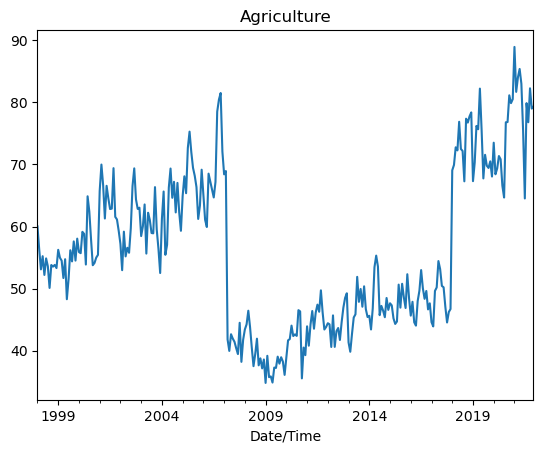

In [18]:
lstm_data = pd.DataFrame(resampled['Agriculture'])
print(lstm_data.head(5))
lstm_data['Agriculture'].plot(title = 'Agriculture')

In [19]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


In [20]:
# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Mean Squared Error (MSE) from the last epoch: 21.190692901611328
R-squared from the last epoch: 0.8090060353279114


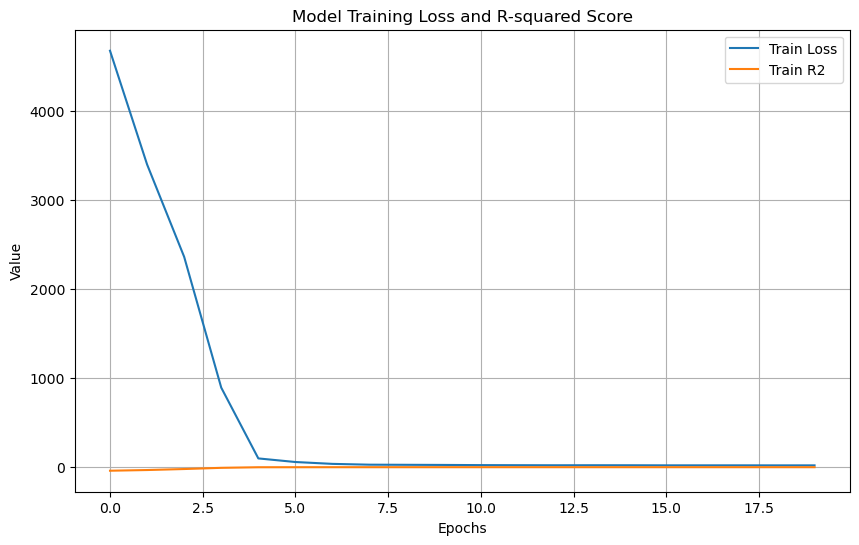

1/1 [==============================] - 0s 277ms/step - loss: 26.5626 - r_squared: 0.3742
MSE and R_squared: [26.562602996826172, 0.3741583228111267]
1/1 [==============================] - 0s 216ms/step
Predictions:
[69.312164, 69.39648, 68.90044, 68.04426, 68.48866, 67.64277, 70.829666, 68.13903, 68.20476, 69.68018]
Actual values:
[71.544346, 69.78615, 69.42995, 70.4949, 68.04646, 73.49505, 68.408988, 69.3503, 71.34813, 70.82587]


In [21]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Univariate Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.4) Ontario

In [22]:
resampled_ON = df[df['provincename'] == 'Ontario']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_ON.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [23]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Agriculture
Date/Time              
1998-01-31    52.912395
1998-02-28    54.301450
1998-03-31    54.553291
1998-04-30    53.190459
1998-05-31    50.819326


<Axes: title={'center': 'Agriculture'}, xlabel='Date/Time'>

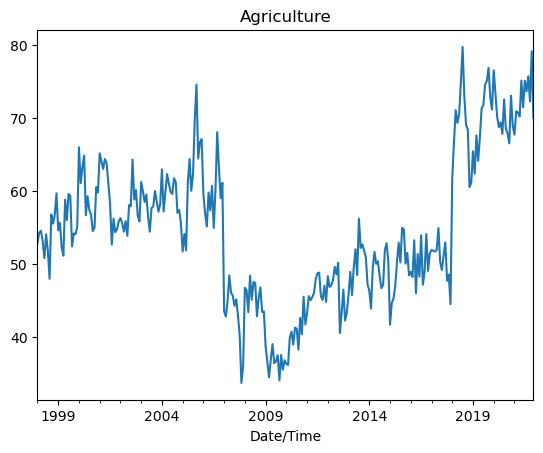

In [24]:
lstm_data = pd.DataFrame(resampled['Agriculture'])
print(lstm_data.head(5))
lstm_data['Agriculture'].plot(title = 'Agriculture')

In [25]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 15.700973510742188
R-squared from the last epoch: 0.784991443157196


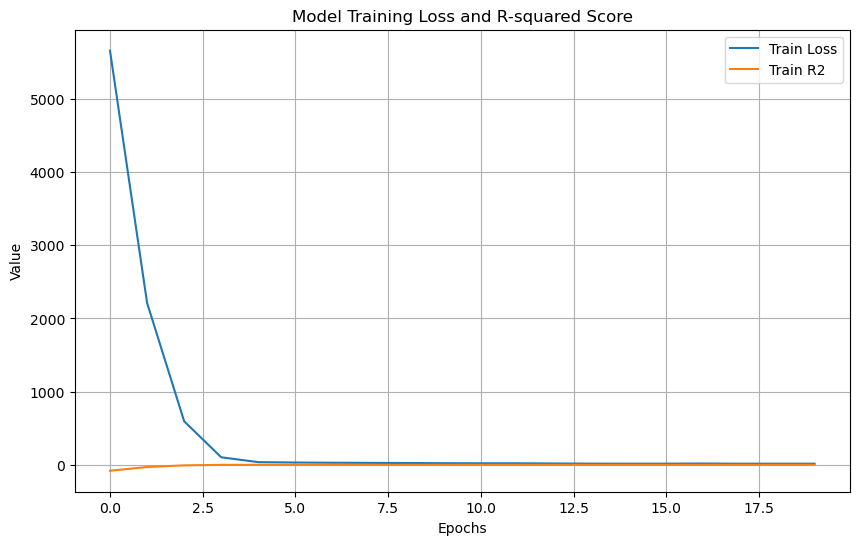

1/1 [==============================] - 0s 341ms/step - loss: 26.0438 - r_squared: -1.6426
MSE and R_squared: [26.0438232421875, -1.6426243782043457]
1/1 [==============================] - 0s 218ms/step
Predictions:
[67.246185, 69.49548, 69.95431, 71.87516, 69.043564, 68.18862, 70.82149, 69.798965, 67.91774, 66.55271]
Actual values:
[74.579166, 75.06355, 76.85068, 72.83112, 71.155959, 76.51055, 73.21728, 70.133582, 68.73774, 69.41754]


In [26]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Univariate Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.5) Quebec

In [27]:
resampled_QC = df[df['provincename'] == 'Quebec']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_QC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [28]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Agriculture
Date/Time              
1998-01-31    26.874227
1998-02-28    26.326112
1998-03-31    26.940388
1998-04-30    25.207708
1998-05-31    25.975333


<Axes: title={'center': 'Agriculture'}, xlabel='Date/Time'>

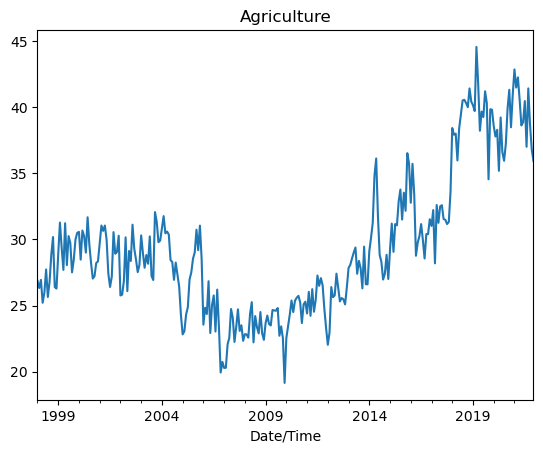

In [29]:
lstm_data = pd.DataFrame(resampled['Agriculture'])
print(lstm_data.head(5))
lstm_data['Agriculture'].plot(title = 'Agriculture')

In [30]:
# Initialize an empty dictionary to store DataFrames for each column
resampled_dataframes = {}

# Iterate over each column name
for column in columns:
    # Get the data for the current column
    column_data = resampled[column]
    
    # Convert to DataFrame and store in the dictionary
    column_data_df = pd.DataFrame(column_data)
    resampled_dataframes[column] = column_data_df
    
    # Display the first 14 rows
    print(f"Data for column '{column}':")
    print(column_data_df.head(3))

Data for column 'Construction':
            Construction
Date/Time               
1998-01-31     44.009793
1998-02-28     47.135313
1998-03-31     48.664697
Data for column 'Transportation and warehousing':
            Transportation and warehousing
Date/Time                                 
1998-01-31                       26.979831
1998-02-28                       28.244141
1998-03-31                       29.007407
Data for column 'Health care and social assistance':
            Health care and social assistance
Date/Time                                    
1998-01-31                          76.390411
1998-02-28                          78.896252
1998-03-31                          79.649614
Data for column 'Agriculture':
            Agriculture
Date/Time              
1998-01-31    26.874227
1998-02-28    26.326112
1998-03-31    26.940388
Data for column 'Wholesale trade Retail trade':
            Wholesale trade Retail trade
Date/Time                               
1998-01-31    

In [31]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

In [32]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 3.260920763015747
R-squared from the last epoch: 0.806118369102478


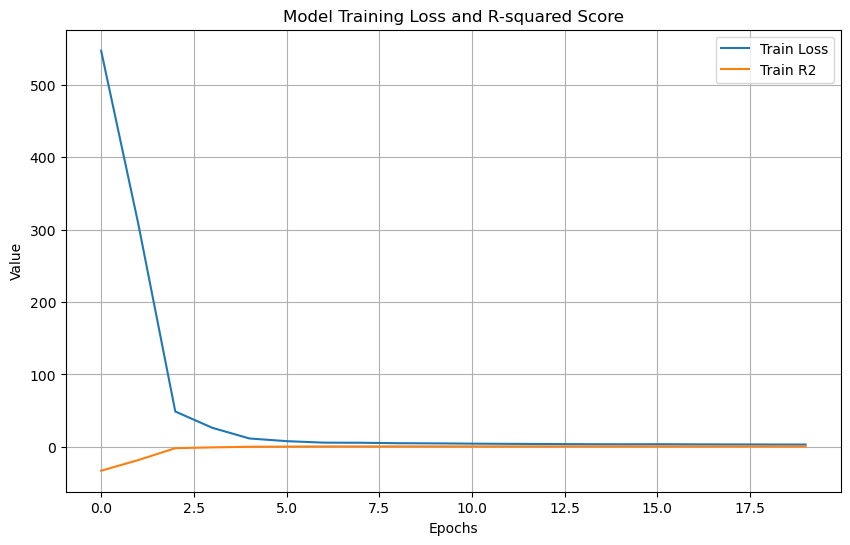

1/1 [==============================] - 0s 250ms/step - loss: 4.7641 - r_squared: -0.0340
MSE and R_squared: [4.764101982116699, -0.03399765491485596]
1/1 [==============================] - 0s 197ms/step
Predictions:
[39.095154, 40.1918, 40.013905, 36.775658, 38.55692, 39.12081, 38.56594, 38.0282, 38.09807, 36.324543]
Actual values:
[41.208808, 40.3126, 34.550464, 39.849373, 39.81639, 38.57825, 37.78665, 38.2897, 35.19231, 39.227084]


In [33]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Quebec: LSTM Univariate Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.6) Saskatchewan

In [34]:
resampled_SK = df[df['provincename'] == 'Saskatchewan']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_SK.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [35]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Agriculture
Date/Time              
1998-01-31    42.952852
1998-02-28    44.485367
1998-03-31    45.829390
1998-04-30    48.011719
1998-05-31    43.700985


<Axes: title={'center': 'Agriculture'}, xlabel='Date/Time'>

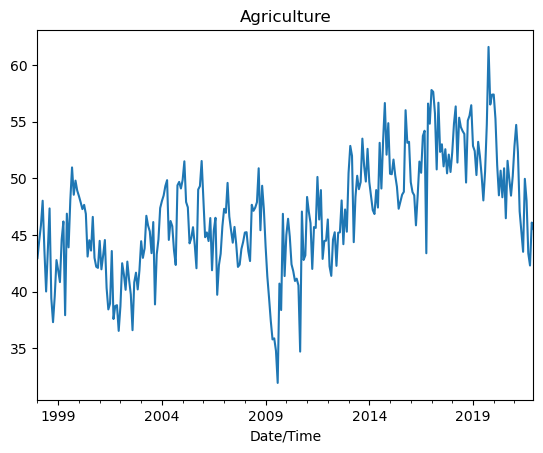

In [36]:
lstm_data = pd.DataFrame(resampled['Agriculture'])
print(lstm_data.head(5))
lstm_data['Agriculture'].plot(title = 'Agriculture')

In [37]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 8.96202278137207
R-squared from the last epoch: 0.590833842754364


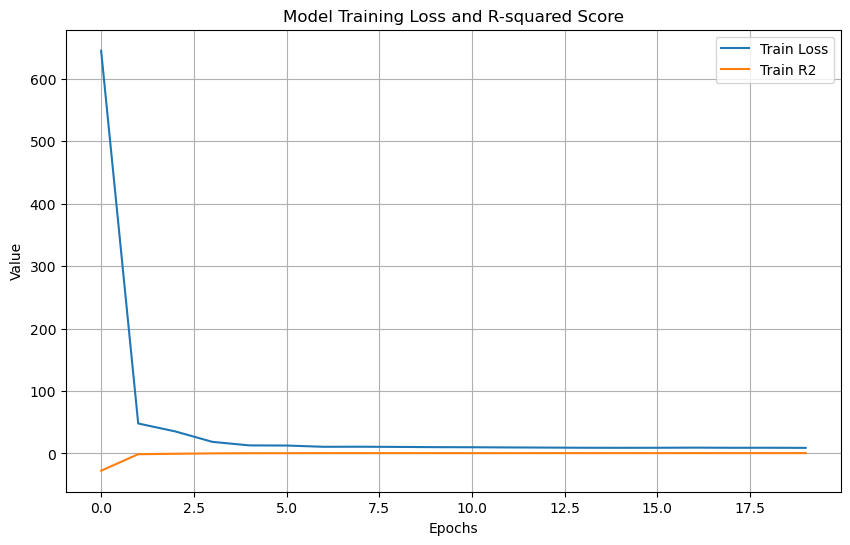

1/1 [==============================] - 0s 296ms/step - loss: 12.3513 - r_squared: 0.4110
MSE and R_squared: [12.351263999938965, 0.4109882712364197]
1/1 [==============================] - 0s 248ms/step
Predictions:
[48.63621, 48.735065, 50.78411, 55.142937, 54.906364, 55.345013, 55.56904, 53.631367, 51.843243, 50.2097]
Actual values:
[50.58778, 54.752438, 61.58152, 56.49865, 57.373229, 57.383281, 55.24053, 51.147191, 48.487562, 50.6632]


In [38]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Saskatchewan: LSTM Univariate Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

## (2) Multivariate ##

In [64]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (15, 6)
mpl.rcParams['axes.grid'] = False

In [65]:
columns = [
    'Agriculture',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)'
]

(2.1) Combination of all 5 provinces

In [471]:
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [472]:
resampled = resampled[columns]
resampled.head()


,Agriculture,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,136.633187,-3.476795,-11.475936,-7.483320,7.229147,-25.824194,62.171390,30.895640,102.139782,16.223433,0.498638,1.321526
1998-02-28,134.821698,2.335362,-6.219163,-1.968022,8.785487,-16.149888,43.465123,9.188011,57.897275,14.411444,0.370572,1.049046
1998-03-31,133.522822,4.270940,-5.059074,-0.388330,15.420638,-16.974551,43.057493,17.122616,65.206267,5.264305,0.326975,1.237057
1998-04-30,131.683532,12.866301,0.774230,6.834755,23.147497,-4.935786,34.318699,2.743902,39.689702,0.143631,0.382114,1.281843
1998-05-31,130.029725,19.732610,6.950949,13.355348,27.606341,0.251378,48.026216,0.022973,53.502432,0.000000,0.491892,1.432432


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

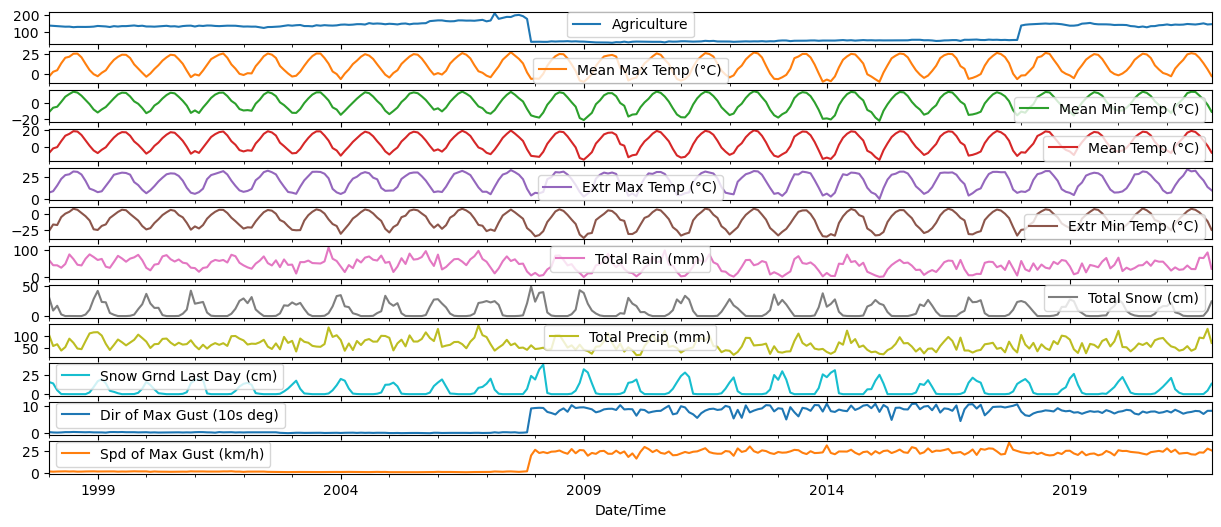

In [473]:
resampled[[
    'Agriculture',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [474]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [475]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)

[136.6331874  -3.4767949 -11.4759355  -7.4833201   7.2291474 -25.8241937
  62.1713896  30.8956403 102.139782   16.2234332   0.4986376   1.3215259]
(204, 12)
[ 47.7259039  -6.9352543 -18.0215015 -12.4107856   5.3361351 -32.7130927
   5.9956757  26.7308108  35.5637838  18.0486486  10.9135135  24.2756757]
(48, 12)


In [476]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i-n_past,0])
    return np.array(dataX),np.array(dataY)    

In [477]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [478]:
train_data_array[0]

array([136.6331874,  -3.4767949, -11.4759355,  -7.4833201,   7.2291474,
       -25.8241937,  62.1713896,  30.8956403, 102.139782 ,  16.2234332,
         0.4986376,   1.3215259])

In [479]:
X_train[0]

array([ -3.4767949, -11.4759355,  -7.4833201,   7.2291474, -25.8241937,
        62.1713896,  30.8956403, 102.139782 ,  16.2234332,   0.4986376,
         1.3215259])

In [480]:
y_train[0]

array([136.6331874])

In [481]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.2883016 -1.1535624 -1.228502  -1.3083715 -1.29608    0.632706
  1.7009449  1.5245554  1.1311881 -0.7845985 -0.7965283]
X_train_scaled: (203, 11)
y_train_scaled: [[0.6627476]
 [0.6280249]
 [0.603128 ]
 [0.5678725]
 [0.5361723]]
y_train_scaled: (203, 1)
X_test_scaled: [-1.5464153 -1.7440852 -1.6452251 -1.5012686 -1.6764014 -1.5506973
  1.767274  -0.9832672  1.5672962  1.3181803  0.1775014]
X_test_scaled: (47, 11)
y_test_scaled: [[-0.5913971]
 [-0.5766062]
 [-0.5914006]
 [-0.5887903]
 [-0.5998518]]
y_test_scaled: (47, 1)


In [482]:
y_train_scaled

array([[ 0.6627476],
       [ 0.6280249],
       [ 0.603128 ],
       [ 0.5678725],
       [ 0.5361723],
       [ 0.542738 ],
       [ 0.4792483],
       [ 0.512498 ],
       [ 0.5050604],
       [ 0.5065265],
       [ 0.5169392],
       [ 0.5447129],
       [ 0.6197708],
       [ 0.5872756],
       [ 0.5636435],
       [ 0.5009976],
       [ 0.5965821],
       [ 0.5532548],
       [ 0.6025817],
       [ 0.6012395],
       [ 0.631933 ],
       [ 0.6749252],
       [ 0.6108663],
       [ 0.6449561],
       [ 0.5599993],
       [ 0.5574386],
       [ 0.5383924],
       [ 0.5698594],
       [ 0.5915556],
       [ 0.6365819],
       [ 0.5677887],
       [ 0.5852446],
       [ 0.5257268],
       [ 0.6069078],
       [ 0.6437443],
       [ 0.6553355],
       [ 0.5568772],
       [ 0.6525211],
       [ 0.6173623],
       [ 0.6721634],
       [ 0.6654845],
       [ 0.6203673],
       [ 0.6014891],
       [ 0.6294361],
       [ 0.6509306],
       [ 0.6515944],
       [ 0.6430869],
       [ 0.60

In [483]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_157 (LSTM)             (None, 1, 128)            71680     
                                                                 
 dropout_151 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_158 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_152 (Dropout)       (None, 128)               0         
                                                                 
 dense_72 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

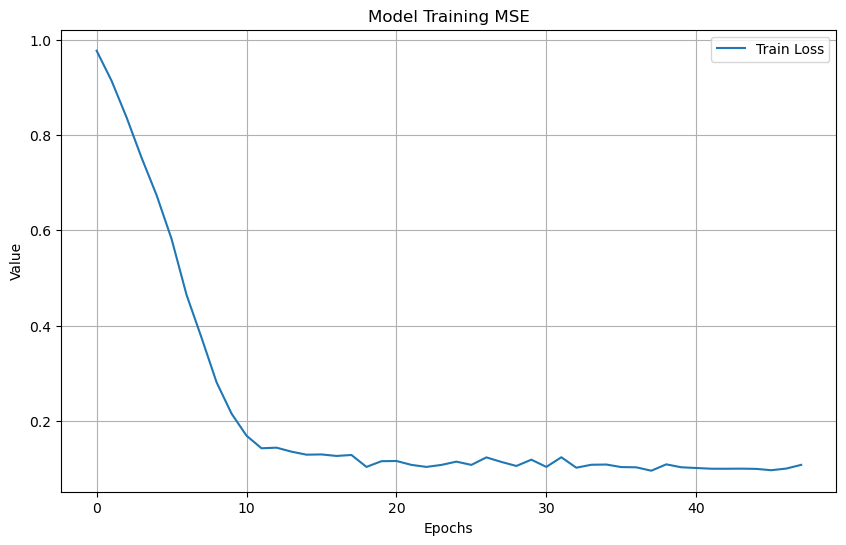

In [484]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [485]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 4ms/step - loss: 0.7901
MSE 0.7900527715682983


In [486]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 0s/step
train_predict: (203, 1)
test_predict: (47, 1)


In [487]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='5 Provinces: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 10.708107329826511
Train Root Mean Squared Error: 14.56681385482851
Train R-squared: 0.9220378968995796


In [488]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='5 Provinces: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 29.504910907492576
Test Root Mean Squared Error: 36.18650791782574
Test R-squared: 0.2099472867010762


(2.2) Alberta

In [489]:
resampled_AB = df[df['provincename'] == 'Alberta']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_AB.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()


,Agriculture,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,653.820231,-9.174123,-19.446359,-14.327202,7.285181,-36.542816,0.085185,16.261111,15.305556,7.611111,1.388889,2.129630
1998-02-28,648.789626,1.726643,-9.481329,-3.892085,9.294639,-18.085026,0.059259,2.807407,2.512963,6.018519,0.240741,0.685185
1998-03-31,645.530682,2.130065,-9.171270,-3.530172,13.286094,-24.753519,1.240741,23.177778,21.712963,2.666667,0.907407,2.814815
1998-04-30,622.510014,13.155375,-0.826884,6.184374,22.869606,-6.995261,14.363636,5.376364,20.041818,0.000000,0.563636,3.236364
1998-05-31,624.691306,20.054474,4.686848,12.396424,27.039213,-1.883615,48.781818,0.000000,49.996364,0.000000,1.636364,4.363636


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

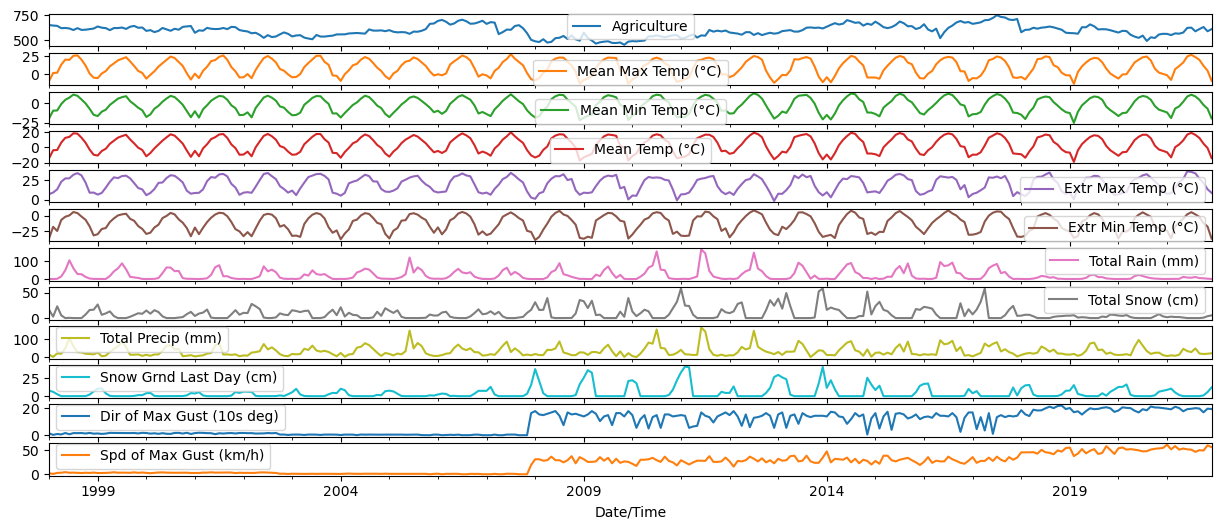

In [490]:
resampled[[
    'Agriculture',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [491]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [492]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 6.5382023e+02 -9.1741231e+00 -1.9446359e+01 -1.4327202e+01
  7.2851810e+00 -3.6542816e+01  8.5185185e-02  1.6261111e+01
  1.5305556e+01  7.6111111e+00  1.3888889e+00  2.1296296e+00]
(204, 12)
[687.9199029  -4.45      -13.8        -9.15       10.75      -31.05
   5.6        23.55       24.7         8.5        16.5        28.       ]
(48, 12)


In [493]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i - n_past,0])
    return np.array(dataX),np.array(dataY)    

In [494]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [495]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.6826387 -1.7324872 -1.7100531 -1.3004064 -1.7700536 -0.7697155
  0.5752101 -0.6544127  0.3521982 -0.6957756 -0.7941258]
X_train_scaled: (203, 11)
y_train_scaled: [[1.1771162]
 [1.0875928]
 [1.0295975]
 [0.6199278]
 [0.6587455]]
y_train_scaled: (203, 1)
X_test_scaled: [-1.2518705 -1.2792955 -1.2710203 -0.9567904 -1.490415  -0.6007109
  1.1776488 -0.4589515  0.9104309  0.4532999 -0.6724978]
X_test_scaled: (47, 11)
y_test_scaled: [[ 0.7635832]
 [ 0.2171122]
 [-0.426764 ]
 [-0.6345594]
 [-0.4143993]]
y_test_scaled: (47, 1)


In [496]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_159 (LSTM)             (None, 1, 128)            71680     
                                                                 
 dropout_153 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_160 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_154 (Dropout)       (None, 128)               0         
                                                                 
 dense_73 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

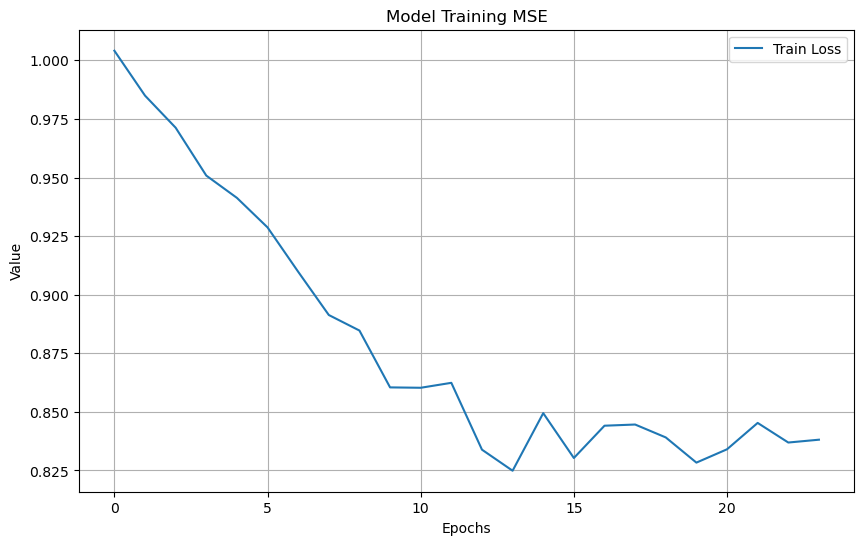

In [497]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [498]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 13ms/step - loss: 0.8680
MSE 0.8680059313774109


In [499]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 16ms/step
train_predict: (203, 1)
test_predict: (47, 1)


In [500]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 41.355393872154124
Train Root Mean Squared Error: 51.036708351344586
Train R-squared: 0.1751076607251476


In [501]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 32.95299151793758
Test Root Mean Squared Error: 43.23470779979307
Test R-squared: 0.13199407710698052


(2.3) Bristish Columbia

In [502]:
resampled_BC = df[df['provincename'] == 'British Columbia']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_BC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Agriculture,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,60.017935,1.668112,-4.154257,-1.238191,9.430297,-17.129487,136.186364,33.692424,191.862121,11.113636,0.234848,1.409091
1998-02-28,56.333245,5.952033,-0.389383,2.724369,10.398405,-6.490740,100.753030,9.244697,122.815152,12.719697,0.234848,1.431818
1998-03-31,53.104132,8.189304,0.355152,4.292350,14.542492,-6.209205,70.272727,7.814394,90.611364,7.219697,0.234848,0.969697
1998-04-30,55.221705,13.038331,2.417762,7.737061,23.675751,-2.323696,45.203030,2.137879,53.328788,0.075758,0.234848,0.954545
1998-05-31,52.203326,18.087071,7.296346,12.687342,26.394613,2.266207,50.971429,0.001504,63.715038,0.000000,0.210526,0.759398


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

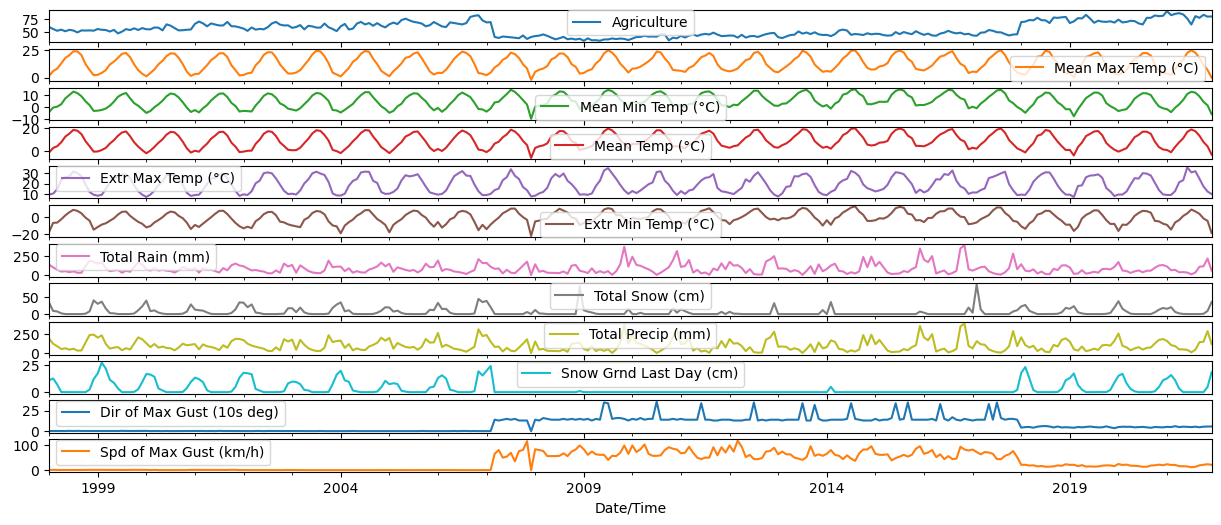

In [503]:
resampled[[
    'Agriculture',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [504]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [505]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 60.0179354   1.6681116  -4.1542568  -1.2381905   9.430297  -17.1294871
 136.1863636  33.6924242 191.8621212  11.1136364   0.2348485   1.4090909]
(204, 12)
[ 47.6427671   7.6         3.3         5.5        12.5        -3.4
 116.8         0.        116.8         0.         15.         65.       ]
(48, 12)


In [506]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)    

In [507]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [508]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.5751278 -1.6301398 -1.6094629 -1.2470013 -2.3188542  0.927755
  2.3789508  1.3828037  1.4007111 -0.8081919 -0.8408499]
X_train_scaled: (203, 11)
y_train_scaled: [[ 0.3215477]
 [ 0.0193243]
 [ 0.2175149]
 [-0.0649851]
 [ 0.1842883]]
y_train_scaled: (203, 1)
X_test_scaled: [-0.9724927 -0.6234884 -0.820507  -1.0452681 -0.7594823  0.2577639
 -0.3508397  0.1556163 -0.2872467  0.0944318  0.5383258]
X_test_scaled: (47, 11)
y_test_scaled: [[-0.6315424]
 [-0.813475 ]
 [-0.8910485]
 [-0.8572299]
 [-0.3416545]]
y_test_scaled: (47, 1)


In [509]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_161 (LSTM)             (None, 1, 128)            71680     
                                                                 
 dropout_155 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_162 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_156 (Dropout)       (None, 128)               0         
                                                                 
 dense_74 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

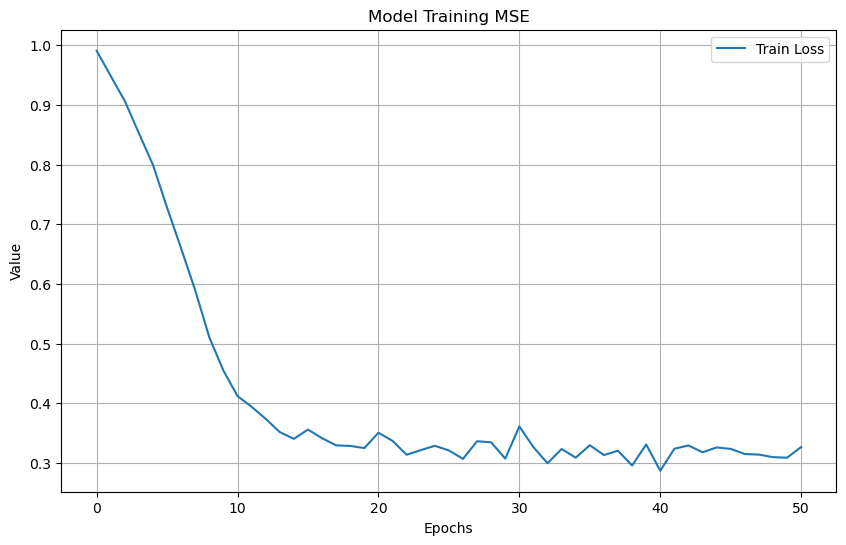

In [510]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [511]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 14ms/step - loss: 0.2341
MSE 0.2340957224369049


In [512]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 0s/step
train_predict: (203, 1)
test_predict: (47, 1)


In [513]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 4.596825388232058
Train Root Mean Squared Error: 5.769502798054957
Train R-squared: 0.7084142981209639


In [514]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 4.529707928329919
Test Root Mean Squared Error: 5.575354693311107
Test R-squared: 0.7659042678214651


(2.4) Ontario

In [515]:
resampled_ON = df[df['provincename'] == 'Ontario']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_ON.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Agriculture,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,52.912395,-1.335346,-8.817714,-5.073900,8.603917,-21.208080,51.952941,32.298039,90.741176,12.921569,0.450980,1.098039
1998-02-28,54.301450,2.038014,-6.539054,-2.244561,8.939422,-17.776302,25.582353,4.156863,31.288235,4.627451,0.607843,1.019608
1998-03-31,54.553291,4.565397,-4.241625,0.163845,21.541639,-17.859510,49.825490,25.756863,77.333333,0.843137,0.078431,1.156863
1998-04-30,53.190459,13.340110,1.406302,7.379227,21.728006,-4.285085,39.958824,0.517647,42.747059,0.000000,0.411765,1.019608
1998-05-31,50.819326,21.705825,9.513872,15.624558,29.795932,2.421586,42.966667,0.031373,47.249020,0.000000,0.470588,1.352941


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

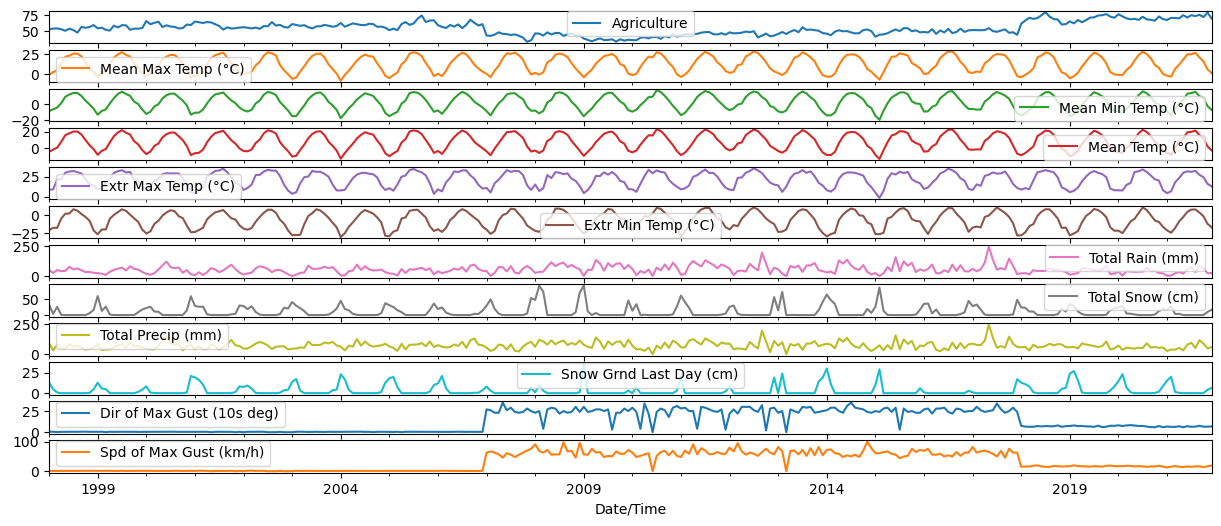

In [516]:
resampled[[
    'Agriculture',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [517]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [518]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 52.9123951  -1.335346   -8.8177137  -5.0739      8.6039171 -21.2080801
  51.9529412  32.2980392  90.7411765  12.9215686   0.4509804   1.0980392]
(204, 12)
[ 41.7078598  -2.6       -14.8        -8.8         5.2       -26.9
  24.6        26.         47.4        10.         25.         61.       ]
(48, 12)


In [519]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i- n_past,0])
    return np.array(dataX),np.array(dataY)    

In [520]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [521]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.3296665 -1.1751887 -1.2572338 -1.4286801 -1.2166938 -0.134898
  1.1176424  0.6131522  1.6094368 -0.8631223 -0.8895057]
X_train_scaled: (203, 11)
y_train_scaled: [[ 0.1174739]
 [ 0.284393 ]
 [ 0.314656 ]
 [ 0.1508881]
 [-0.1340446]]
y_train_scaled: (203, 1)
X_test_scaled: [-1.4744108 -1.7602623 -1.6256451 -1.7361759 -1.641118  -0.846613
  0.8663017 -0.7427338  1.412211   0.4440937  0.4863386]
X_test_scaled: (47, 11)
y_test_scaled: [[-1.415713 ]
 [-1.0902205]
 [-1.0228546]
 [-0.8317871]
 [-0.477093 ]]
y_test_scaled: (47, 1)


In [522]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_163 (LSTM)             (None, 1, 128)            71680     
                                                                 
 dropout_157 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_164 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_158 (Dropout)       (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

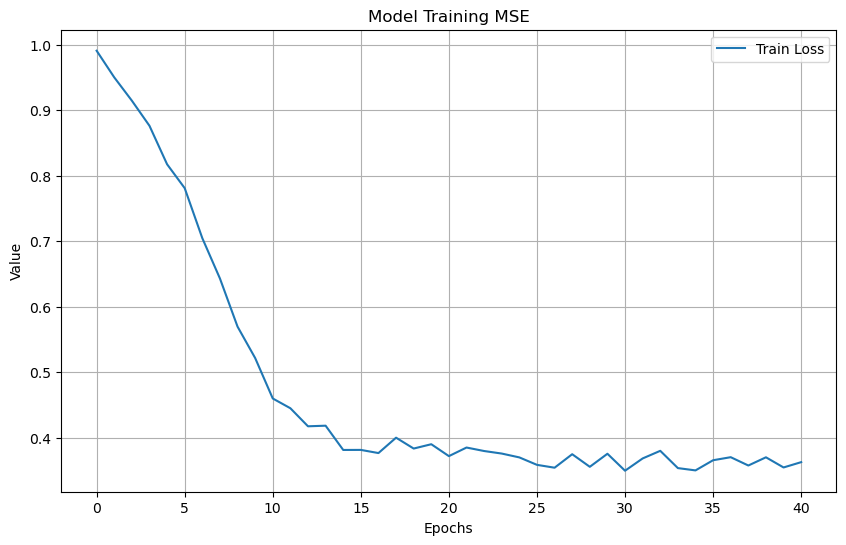

In [523]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [524]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 0s/step - loss: 0.2382
MSE 0.23823340237140656


In [525]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 0s/step
train_predict: (203, 1)
test_predict: (47, 1)


In [526]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 3.830995874982936
Train Root Mean Squared Error: 4.87484008303272
Train R-squared: 0.6568425182226797


In [527]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 3.379705732238625
Test Root Mean Squared Error: 4.433093817736252
Test R-squared: 0.7617666188181731


(2.5) Quebec

In [596]:
resampled_QC = df[df['provincename'] == 'Quebec']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_QC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Agriculture,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,26.874227,-4.552563,-13.994682,-9.287824,5.741158,-29.829489,25.681176,43.316471,69.741176,35.976471,0.364706,0.847059
1998-02-28,26.326112,-0.896600,-11.473360,-6.188613,7.167492,-25.858277,14.797647,16.928235,32.250588,31.517647,0.329412,0.670588
1998-03-31,26.940388,2.044358,-7.643261,-2.797791,15.422714,-22.235325,45.856471,28.203529,75.307059,7.600000,0.341176,0.694118
1998-04-30,25.207708,11.654923,-0.400211,5.643657,22.055794,-6.318341,38.970588,4.340000,43.837647,0.505882,0.317647,0.658824
1998-05-31,25.975333,20.997578,7.887234,14.470646,28.402177,-0.216450,57.038824,0.000000,57.442353,0.000000,0.105882,0.717647


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

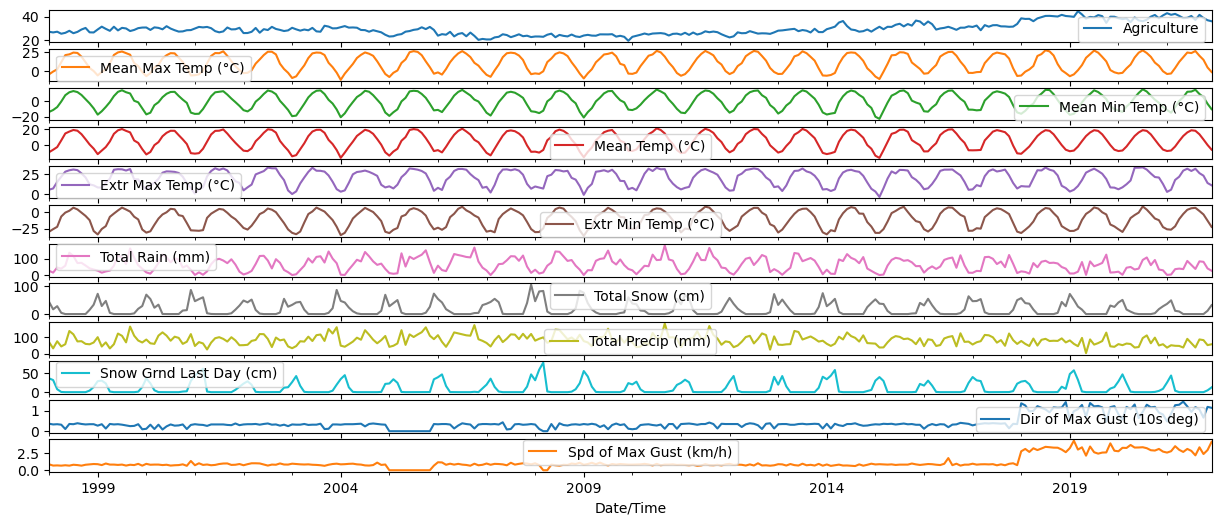

In [597]:
resampled[[
    'Agriculture',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [598]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [599]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 26.874227   -4.5525631 -13.9946817  -9.2878244   5.7411585 -29.8294891
  25.6811765  43.3164706  69.7411765  35.9764706   0.3647059   0.8470588]
(204, 12)
[ 29.2253616  -7.5620562 -20.2226006 -13.720897    3.3433728 -31.6792533
  11.3325301  52.6204819  60.9192771  30.          0.3373494   0.8313253]
(48, 12)


In [600]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i- n_past,0])
    return np.array(dataX),np.array(dataY)    

In [601]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [602]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.3641295 -1.3546768 -1.3667059 -1.4833804 -1.5049106 -0.9940246
  1.0252386 -0.5745122  1.6325595  0.7755932  0.3793856]
X_train_scaled: (203, 11)
y_train_scaled: [[ 0.0360244]
 [-0.15118  ]
 [ 0.0586212]
 [-0.5331621]
 [-0.270986 ]]
y_train_scaled: (203, 1)
X_test_scaled: [-1.6113795 -1.9288515 -1.7962005 -1.6839271 -1.612155  -1.4312386
  1.6855411 -0.7528538  1.5976548 -0.5184163 -0.5670676]
X_test_scaled: (47, 11)
y_test_scaled: [[-1.1430356]
 [-0.6063585]
 [-1.1873156]
 [-0.6150978]
 [-0.6415003]]
y_test_scaled: (47, 1)


In [603]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_176 (LSTM)             (None, 1, 128)            71680     
                                                                 
 dropout_172 (Dropout)       (None, 1, 128)            0         
                                                                 
 dropout_173 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_177 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_174 (Dropout)       (None, 128)               0         
                                                                 
 dropout_175 (Dropout)       (None, 128)               0         
                                                                 
 dense_81 (Dense)            (None, 1)               

Train Mean Squared Error (MSE) from the last epoch: 0.9596024751663208


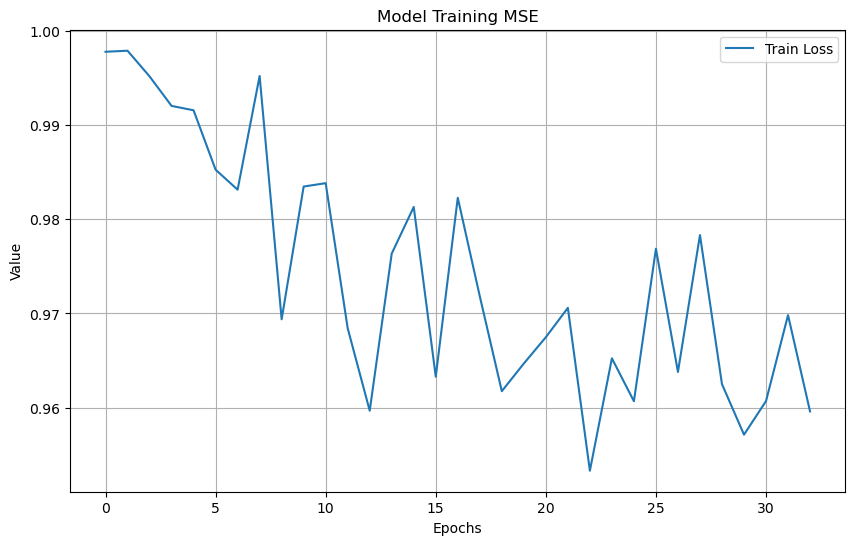

In [604]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [605]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 17ms/step - loss: 1.1189
MSE 1.1188979148864746


In [606]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 2ms/step
train_predict: (203, 1)
test_predict: (47, 1)


In [607]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Quebec: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 2.354281595126674
Train Root Mean Squared Error: 2.8567853886048393
Train R-squared: 0.04798438971162611


In [608]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Quebec: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 3.194656396805522
Test Root Mean Squared Error: 3.887683727139741
Test R-squared: -0.11889798390909512


(2.6) Saskatchewan

In [610]:
resampled_SK = df[df['provincename'] == 'Saskatchewan']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_SK.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Agriculture,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,42.952852,-12.126696,-21.643371,-16.911877,1.957775,-36.132356,0.071111,15.202222,17.271111,7.977778,0.511111,1.244444
1998-02-28,44.485367,-1.101262,-9.118113,-5.137857,6.325029,-21.979885,1.924444,7.760000,12.533333,8.222222,0.733333,1.111111
1998-03-31,45.829390,-0.781830,-12.051365,-6.422710,13.616929,-28.278167,0.448889,6.444444,10.053333,3.244444,0.155556,1.244444
1998-04-30,48.011719,13.740122,-0.558231,6.620447,25.554963,-8.135638,12.095652,0.854348,12.989130,0.000000,0.673913,1.326087
1998-05-31,43.700985,19.580392,4.087789,11.856558,27.889747,-4.563031,27.563043,0.145652,27.819565,0.000000,0.673913,1.282609


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

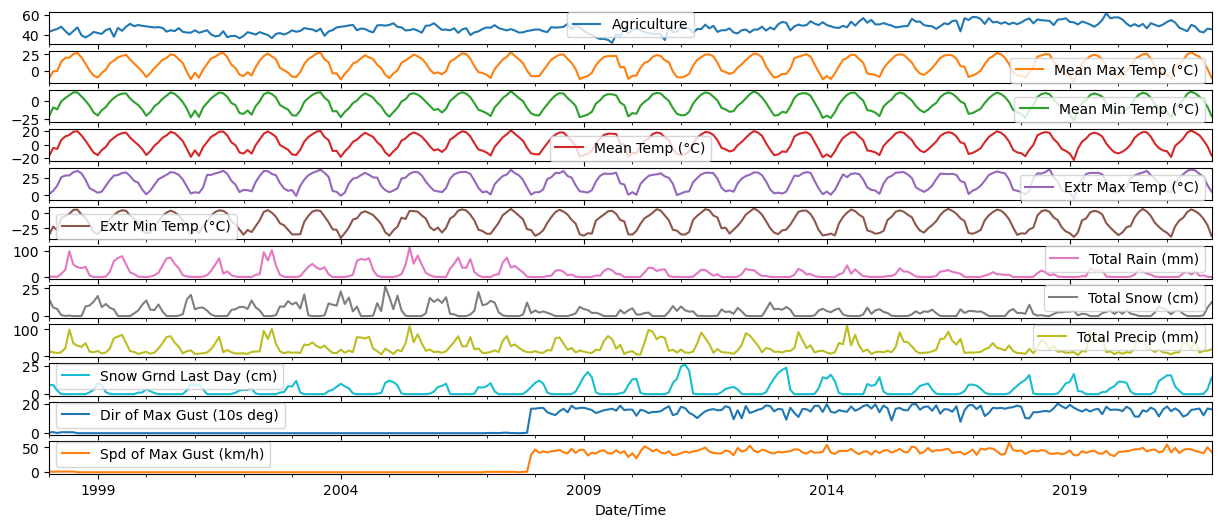

In [611]:
resampled[[
    'Agriculture',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [612]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [613]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 42.9528522 -12.1266961 -21.6433711 -16.9118767   1.9577753 -36.1323565
   0.0711111  15.2022222  17.2711111   7.9777778   0.5111111   1.2444444]
(204, 12)
[ 50.3918039  -6.6476672 -16.4938972 -11.5873559   6.8416841 -33.9810626
   0.1632653   5.1489796  13.3612245   8.3877551  19.5714286  43.2653061]
(48, 12)


In [614]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i - n_past,0])
    return np.array(dataX),np.array(dataY)    

In [615]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [616]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.6698373 -1.6490755 -1.66314   -1.5666557 -1.5650135 -0.7730117
  1.8995937 -0.5883483  0.8292041 -0.7658843 -0.7775881]
X_train_scaled: (203, 11)
y_train_scaled: [[-0.4744195]
 [-0.0944447]
 [ 0.238795 ]
 [ 0.7798859]
 [-0.2889261]]
y_train_scaled: (203, 1)
X_test_scaled: [-1.3170818 -1.3160303 -1.3195223 -1.2290252 -1.4689573 -0.8956713
  1.164457  -0.7668967  1.1554668  1.2146221  0.1569657]
X_test_scaled: (47, 11)
y_test_scaled: [[-0.51862  ]
 [-0.5321166]
 [-0.1252638]
 [-0.5622629]
 [-0.8802835]]
y_test_scaled: (47, 1)


In [617]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_178 (LSTM)             (None, 1, 128)            71680     
                                                                 
 dropout_176 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_179 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_177 (Dropout)       (None, 128)               0         
                                                                 
 dense_82 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

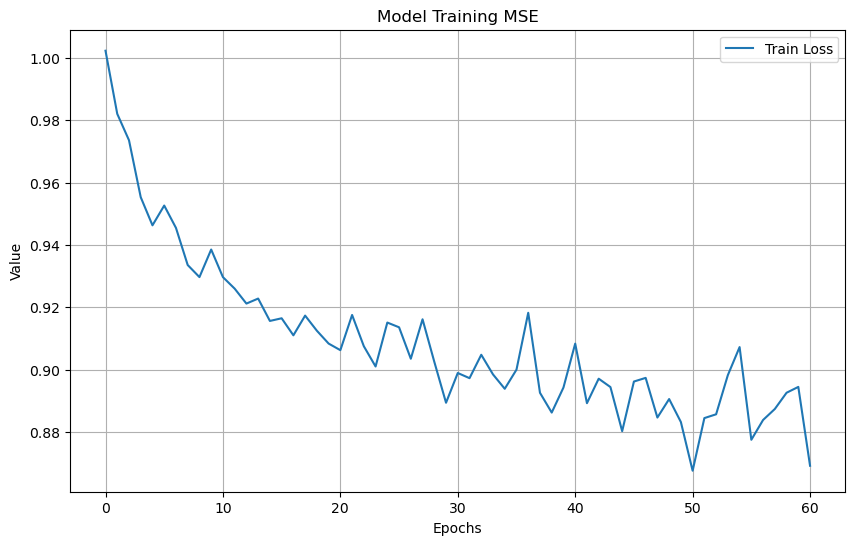

In [618]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
model.add(Dropout(0.5))
model.add(LSTM(128))
# model.add(Dropout(0.3))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [619]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 8ms/step - loss: 0.9565
MSE 0.956456184387207


In [620]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 0s/step
train_predict: (203, 1)
test_predict: (47, 1)


In [621]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Saksatchewan: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 3.0360991906365147
Train Root Mean Squared Error: 3.778077190691987
Train R-squared: 0.12251090677845133


In [622]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Saksatchewan: LSTM Prediction on Agriculture',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Agriculture'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 2.601771569098077
Test Root Mean Squared Error: 3.1160639888377792
Test R-squared: 0.043543775680286334
